### Описание набора данных
Набор данных о зарплатах в Data Science содержит 11 колонок, каждая из которых:

- **work_year**: Год, в котором была выплачена зарплата.
- **experience_level**: Уровень опыта на работе в течение данного года.
- **employment_type**: Тип занятости для данной роли.
- **job_title**: Название должности, на которой работали в течение года.
- **salary**: Общая сумма выплаченной брутто-зарплаты.
- **salary_currency**: Валюта, в которой выплачивалась зарплата, в формате ISO 4217.
- **salary_in_usd**: Зарплата, переведённая в доллары США.
- **employee_residence**: Основная страна проживания сотрудника в течение рабочего года в формате ISO 3166.
- **remote_ratio**: Общая доля работы, выполненной удалённо.
- **company_location**: Страна, где находится главный офис работодателя или его филиал.
- **company_size**: Среднее количество сотрудников, работавших в компании в течение года.

# 1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, RegressorMixin

from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from category_encoders import OneHotEncoder, TargetEncoder, BinaryEncoder
from mlxtend.plotting import plot_decision_regions

# 2. Загрузка набора данных

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

sns.set(style="whitegrid", palette="muted")

warnings.filterwarnings("ignore")

df1 = pd.read_csv("datasets/ds_salaries.csv")
df2 = pd.read_csv("datasets/salaries.csv")
df3 = pd.read_csv("datasets/ds_salary_2024.csv")


print("Размер 1-го датасета: ", df1.shape)
print("Размер 2-го датасета: ", df2.shape)
print("Размер 3-го датасета: ", df3.shape)

Размер 1-го датасета:  (3755, 11)
Размер 2-го датасета:  (13730, 11)
Размер 3-го датасета:  (16534, 11)


## 1.2 **Просмотр датафреймов**

In [3]:
print("Первый датасет:")
display(df1.head(5))

print("Второй датасет:")
display(df2.head(5))

print("Третый датасет:")
display(df3.head(5))


Первый датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


Второй датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,AI Architect,800000,USD,800000,CA,100,CA,M
1,2023,EN,FT,Data DevOps Engineer,44382,EUR,47918,NL,50,NL,L
2,2024,EN,FT,Data Analyst,40100,EUR,44555,LT,0,LT,M
3,2024,EN,FT,Data Analyst,28069,EUR,31187,LT,0,LT,M
4,2024,SE,FT,Data Engineer,220000,USD,220000,US,0,US,M


Третый датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,AI Engineer,202730,USD,202730,US,0,US,M
1,2024,SE,FT,AI Engineer,92118,USD,92118,US,0,US,M
2,2024,SE,FT,Data Engineer,130500,USD,130500,US,0,US,M
3,2024,SE,FT,Data Engineer,96000,USD,96000,US,0,US,M
4,2024,SE,FT,Machine Learning Engineer,190000,USD,190000,US,0,US,M


## **Объединение датафреймов**

In [4]:
# Объединение по строкам
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True).drop_duplicates()

# Проверка размера нового датасета
print(f"Размер датасета после объеденения и удаления дубликатов: {df.shape}")

# Проверим результат
display(df.head())

Размер датасета после объеденения и удаления дубликатов: (10287, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


# 3. Исследование и очистка данных


## 3.1. **Пропущенные значения:**

In [5]:
print("Пропущенные значения в столбцах:")
df.isna().sum()

Пропущенные значения в столбцах:


work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

## 3.2. **Типы данных:**

In [6]:
print("Типы данных:")
df.dtypes.sort_values()

Типы данных:


work_year              int64
salary                 int64
salary_in_usd          int64
remote_ratio           int64
experience_level      object
employment_type       object
job_title             object
salary_currency       object
employee_residence    object
company_location      object
company_size          object
dtype: object

## 3.3. **Описательная статистика:**

In [7]:
print("Описательные статистики:")
df.describe().round(2)

Описательные статистики:


,work_year,salary,salary_in_usd,remote_ratio
count,10287.00,10287.00,10287.00,10287.00
mean,2023.22,170836.71,145168.71,35.80
std,0.79,433629.56,73302.93,47.25
min,2020.00,6000.00,5132.00,0.00
25%,2023.00,95000.00,93869.00,0.00
50%,2023.00,139200.00,137141.00,0.00
75%,2024.00,187635.00,185000.00,100.00
max,2024.00,30400000.00,800000.00,100.00


## 3.4. **Количество уникальных значений:**

In [8]:
print("Количество уникальных значений в каждом столбце: ")
df.nunique()

Количество уникальных значений в каждом столбце: 


work_year                5
experience_level         4
employment_type          4
job_title              157
salary                2577
salary_currency         24
salary_in_usd         3052
employee_residence      91
remote_ratio             3
company_location        83
company_size             3
dtype: int64

## 3.5. **Дубликаты:**

In [9]:
dublicated = df.duplicated().sum()
print(f"Количество дубликатов: {dublicated}")

Количество дубликатов: 0


# 4. Исследовательский анализ данных (EDA)
## a) Распределение заработной платы в долларах США

Смещение ЗП от среднего: 1.59


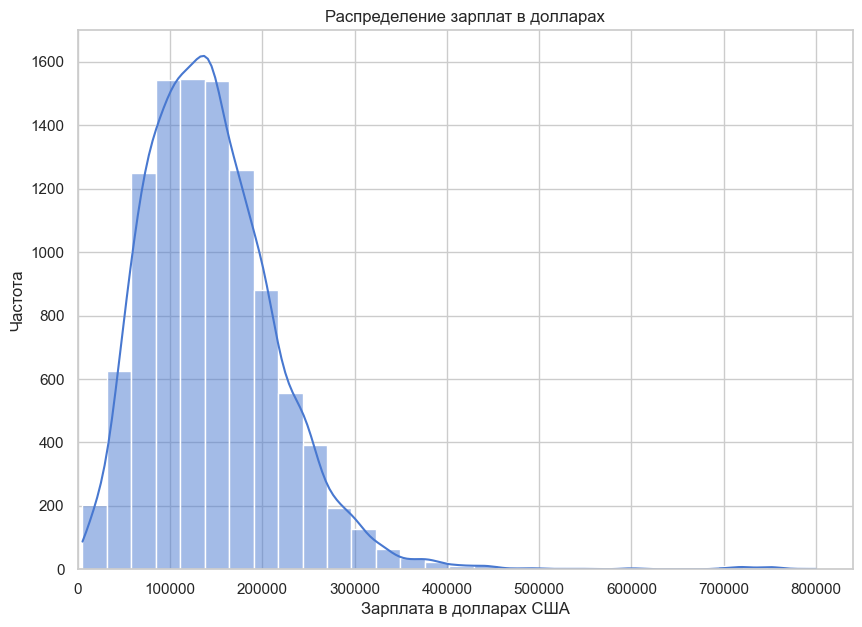

In [10]:
skewness = df['salary_in_usd'].skew()
print(f"Смещение ЗП от среднего: {skewness:.2f}")

plt.figure(figsize=(10, 7))
sns.histplot(df, x="salary_in_usd", kde=True, bins=30)
plt.title("Распределение зарплат в долларах")
plt.xlabel("Зарплата в долларах США")
plt.ylabel("Частота")
plt.xlim(0)
plt.savefig("plots/Распределение_зарплат_в_долларах.png", dpi=300, bbox_inches='tight')
plt.show()

## b) Зарплата по уровню опыта (Boxplot)

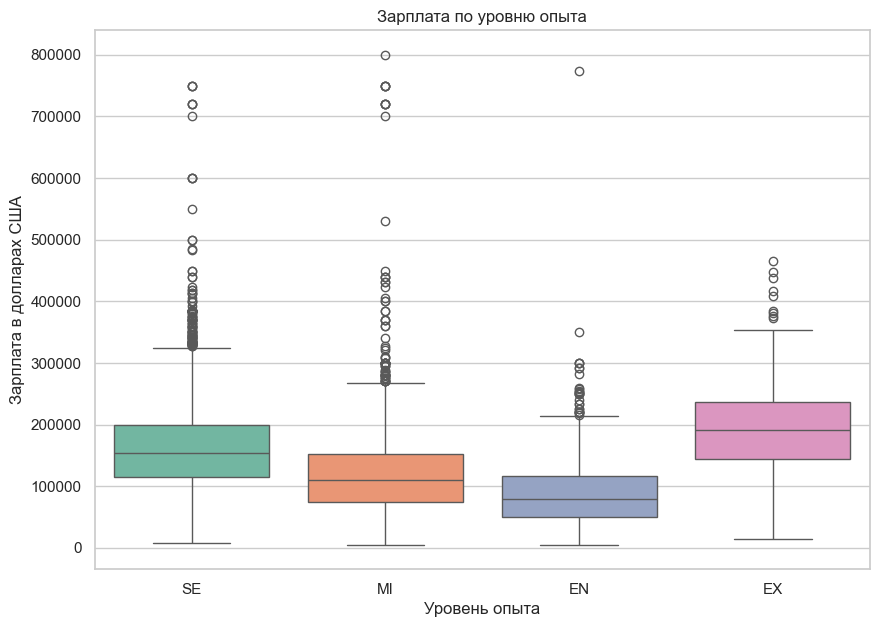

In [11]:
plt.figure(figsize=(10, 7))
sns.boxplot(df, x="experience_level", y="salary_in_usd", palette="Set2")
plt.title("Зарплата по уровню опыта")
plt.xlabel("Уровень опыта")
plt.ylabel("Зарплата в долларах США")
plt.savefig("plots/Зарплата_по_уровню_опыта.png", dpi=300, bbox_inches='tight')
plt.show()

**Уровень опыта сотрудников:**  

- **SE (Senior)** – **Старший специалист**: Опытный профессионал с глубокими знаниями в своей области, способный брать на себя сложные задачи и руководить проектами.  
- **MI (Mid-Level)** – **Средний уровень**: Специалист с достаточным опытом, способный работать автономно, но всё же не на уровне эксперта.  
- **EN (Entry-Level)** – **Начальный уровень (Junior)**: Специалист на старте карьеры, обычно с ограниченным опытом, но готовый обучаться.  
- **EX (Executive/Director)** – **Руководитель/Директор**: Человек на руководящей должности, отвечающий за стратегические решения и управление командой.  

## c) Частота названий должностей (Countplot)

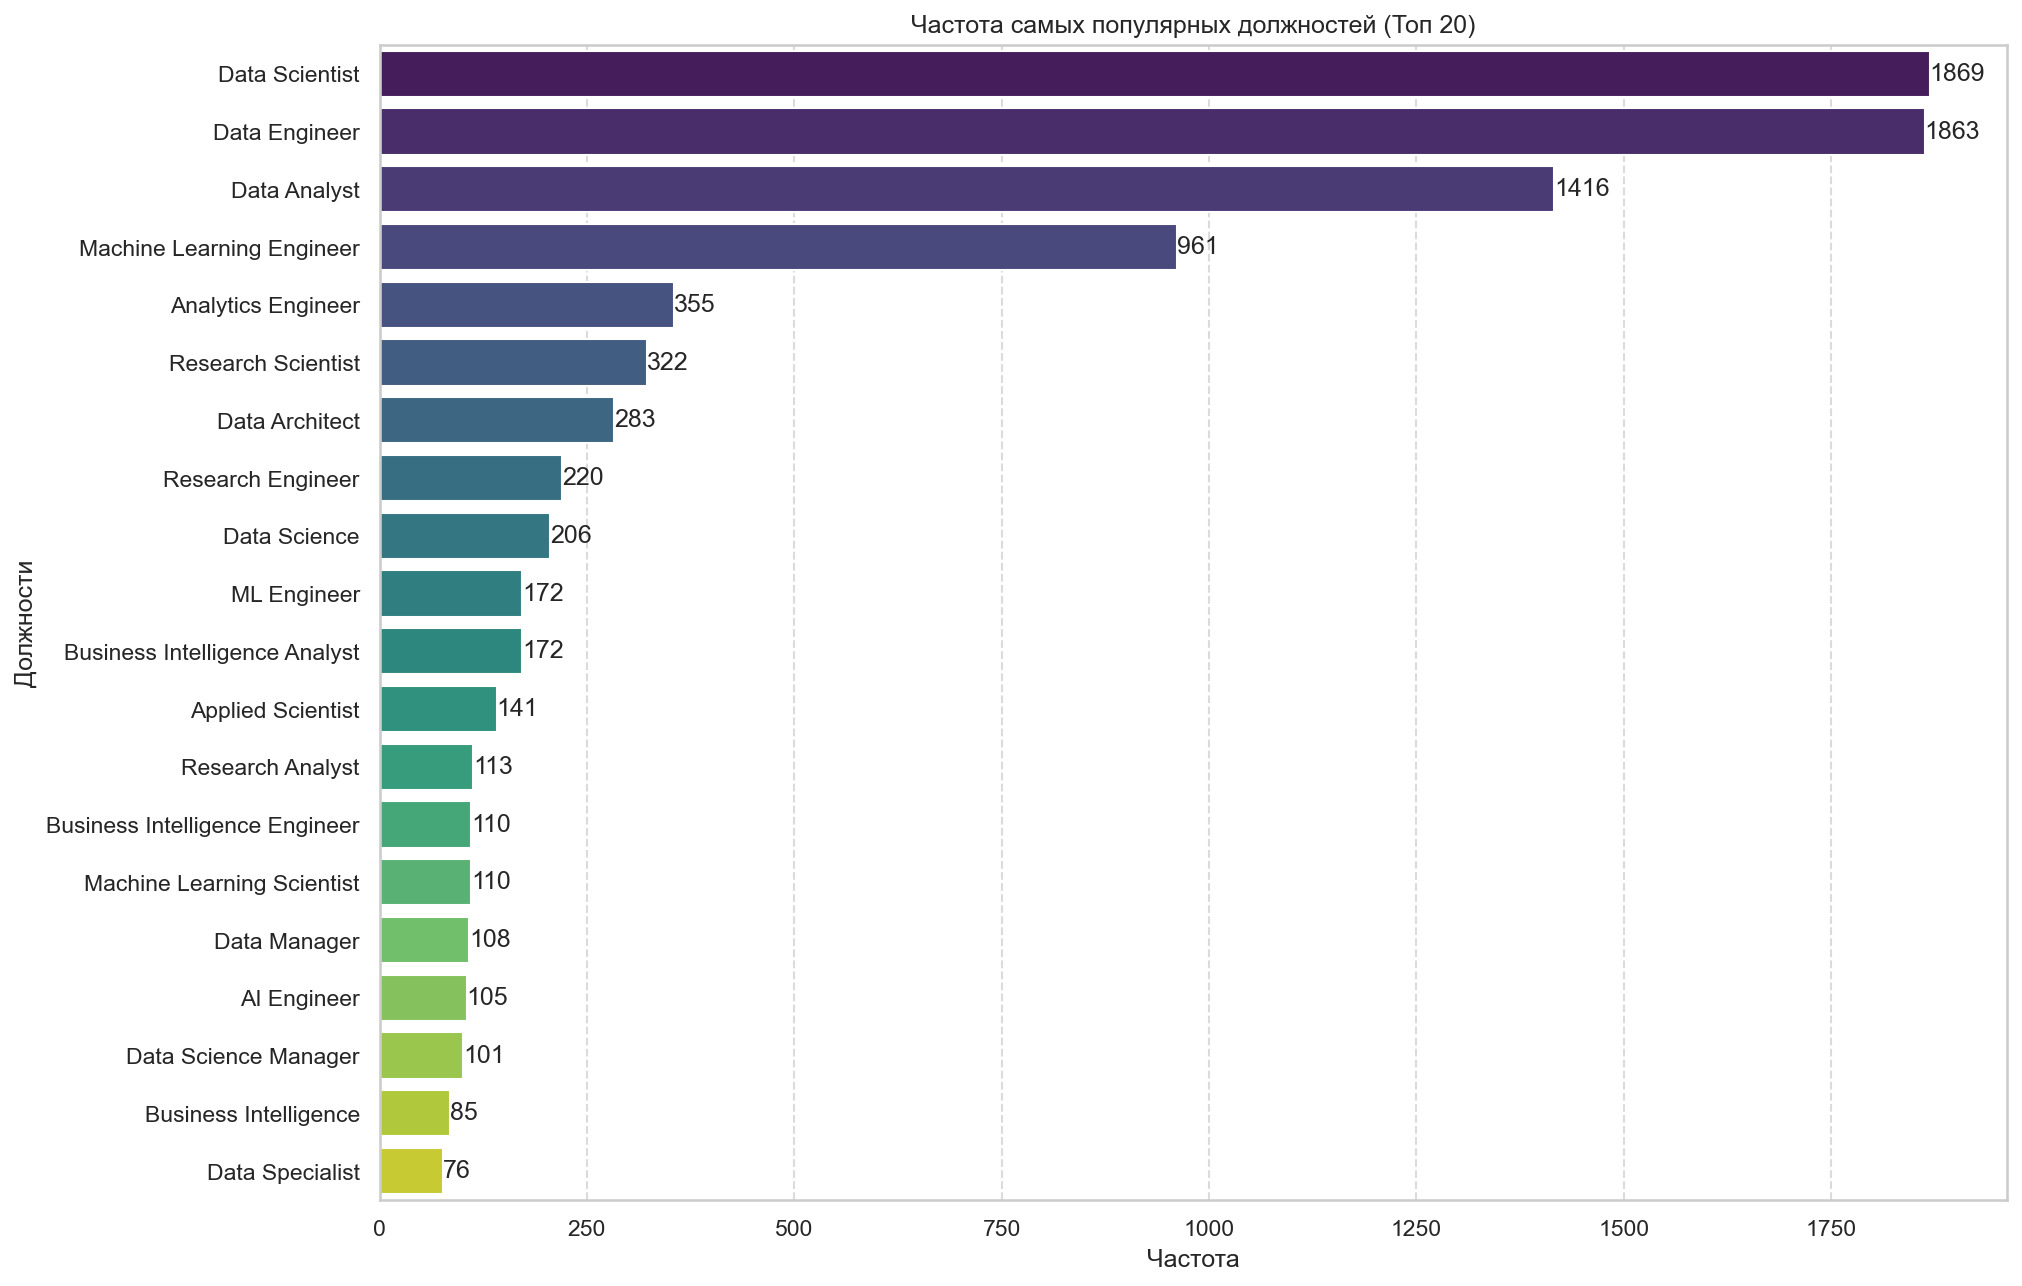

In [12]:
plt.figure(figsize=(14, 10), dpi=150)

top_job_titles = df["job_title"].value_counts().nlargest(20)

sns.barplot(y=top_job_titles.index, x=top_job_titles.values, palette="viridis")
plt.title("Частота самых популярных должностей (Топ 20)")
plt.xlabel("Частота")
plt.ylabel("Должности")

for index, value in enumerate(top_job_titles):
    plt.text(value, index, str(value), va="center")
    
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.savefig("plots/Частота_самых_популярных_должностей.png", dpi=300, bbox_inches='tight')
plt.show()

## d) Коэффициент удаленной работы vs зарплата (Scatterplot)

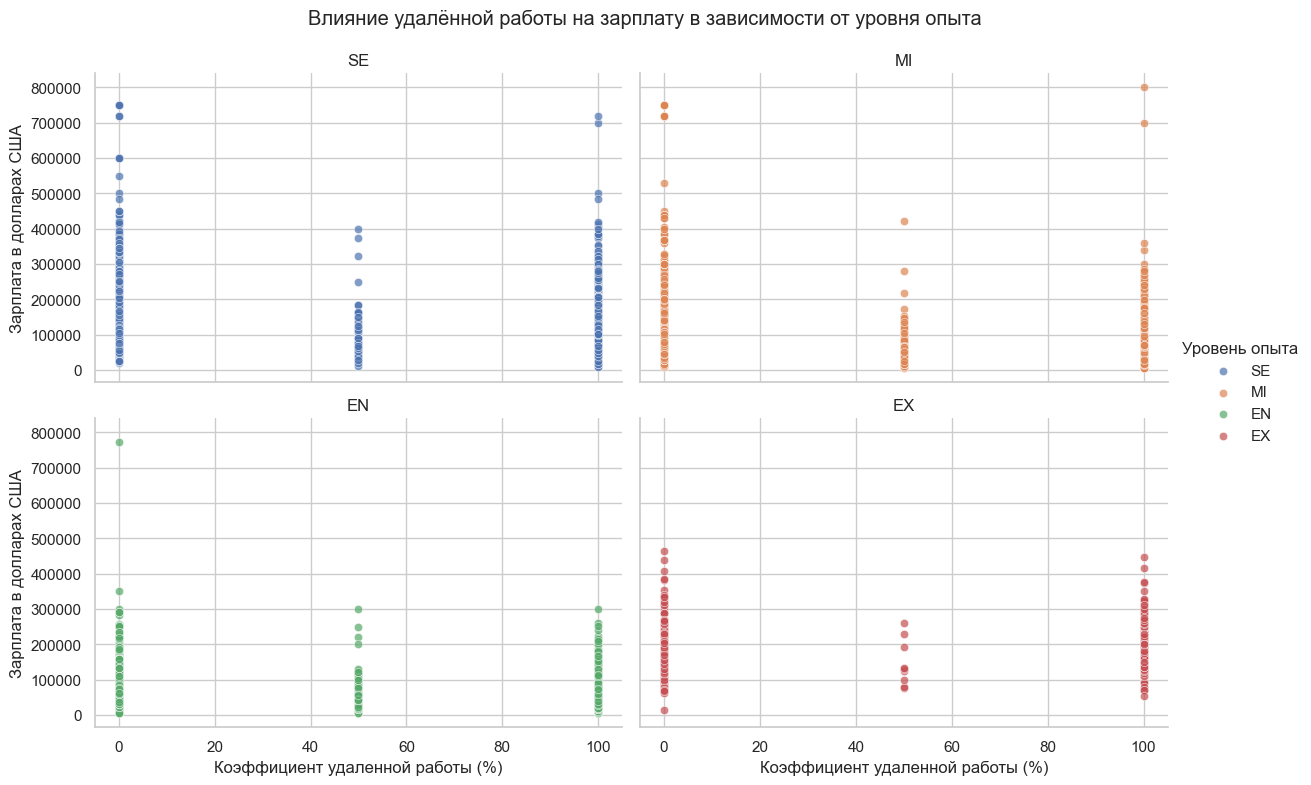

In [13]:
g = sns.FacetGrid(df, col="experience_level", col_order=['SE', 'MI', 'EN', 'EX'], col_wrap=2, height=4, aspect=1.5, hue="experience_level", palette="deep")

g.map_dataframe(sns.scatterplot, x="remote_ratio", y="salary_in_usd", alpha=0.7)
g.set_axis_labels("Коэффициент удаленной работы (%)", "Зарплата в долларах США")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Уровень опыта")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Влияние удалённой работы на зарплату в зависимости от уровня опыта")

plt.savefig("plots/Влияние_удалённой_работы_на_зарплату.png", dpi=300, bbox_inches='tight')
plt.show()

## e) Средняя зарплата по должностям (Bar Plot)

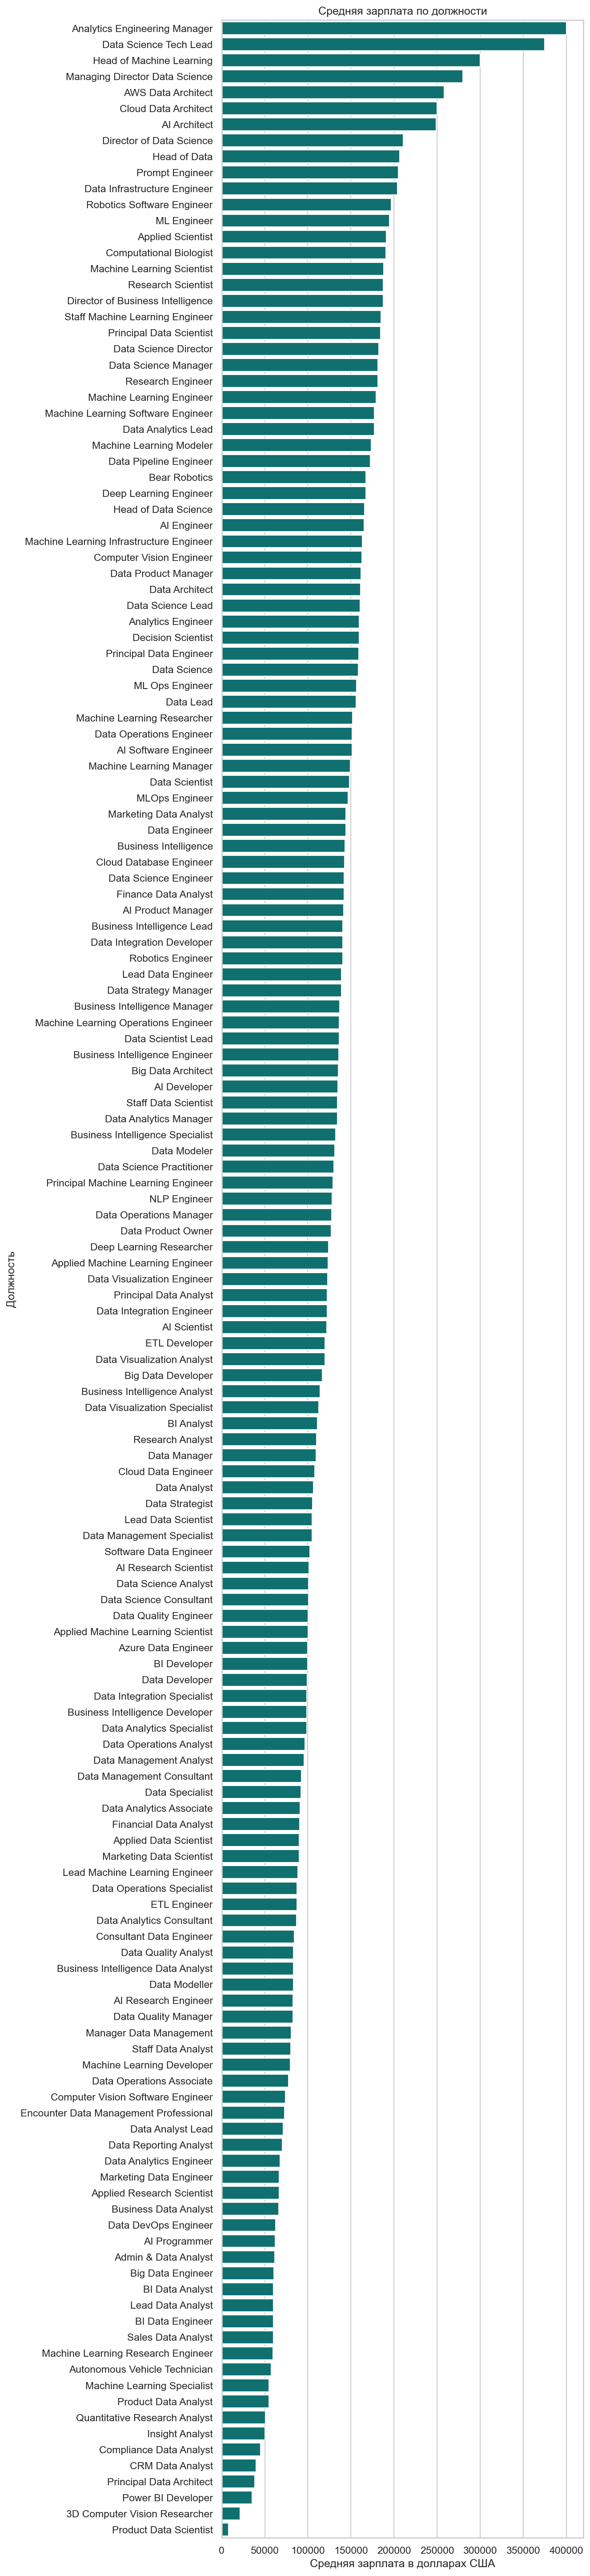

In [14]:
plt.figure(figsize=(7, 49), dpi=150)
job_salary = df.groupby('job_title')["salary_in_usd"].mean().sort_values(ascending=False).round()

sns.barplot(y=job_salary.index, x=job_salary.values, color="teal")
plt.title("Средняя зарплата по должности")
plt.xlabel("Средняя зарплата в долларах США")
plt.ylabel("Должность")
plt.show()

## f) Изменение заработной платы по годам (Bar Plot)

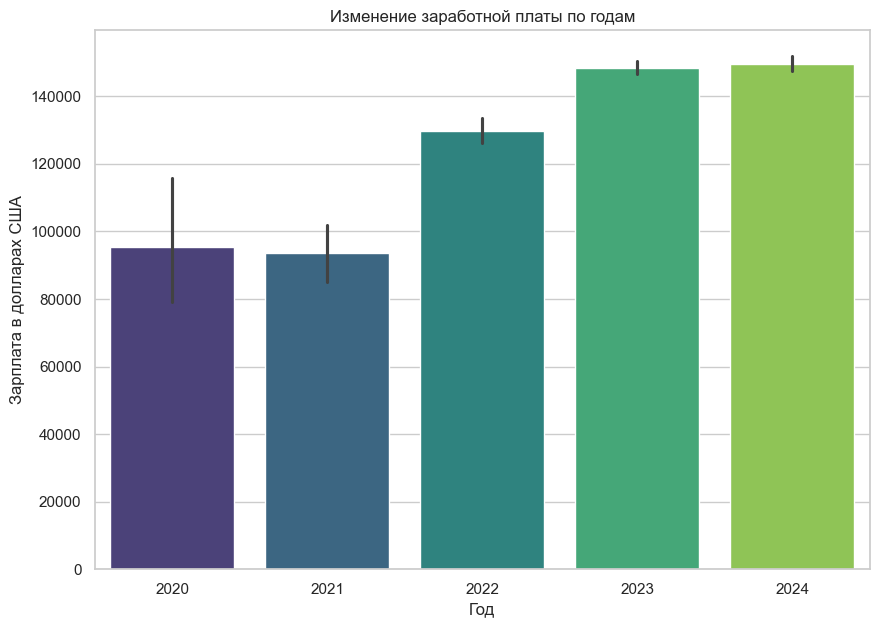

In [15]:
plt.figure(figsize=(10, 7))
sns.barplot(df, x="work_year", y="salary_in_usd", palette="viridis")
plt.title("Изменение заработной платы по годам")
plt.xlabel("Год")
plt.ylabel("Зарплата в долларах США")
plt.show()

## g) Изменение заработной платы по годам в зависимости от уровня опыта

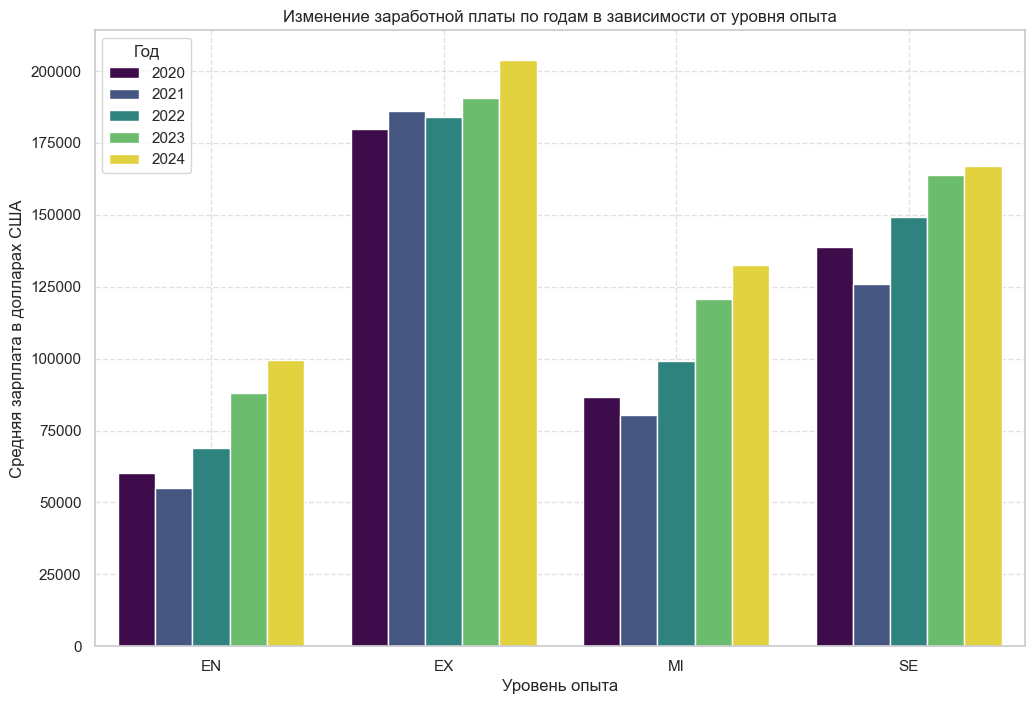

In [16]:
exp_salary = df.groupby(['experience_level', 'work_year'])['salary_in_usd'].mean().round().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=exp_salary, hue="work_year", y="salary_in_usd", x="experience_level", palette="viridis")

plt.title("Изменение заработной платы по годам в зависимости от уровня опыта")
plt.xlabel("Уровень опыта")
plt.ylabel("Средняя зарплата в долларах США")
plt.legend(title="Год")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("plots/Изменение_заработной_платы.png", dpi=300, bbox_inches='tight')
plt.show()

## h) Тепловая карта корреляции для числовых признаков

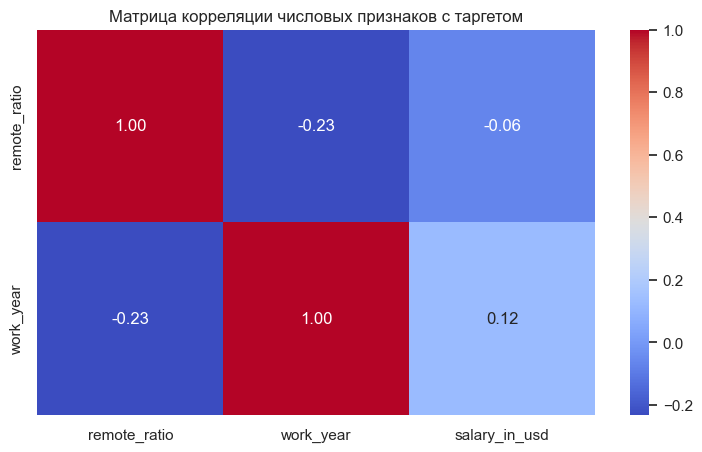

In [17]:
numeric_cols = df.select_dtypes("number").drop(columns="salary").columns.sort_values().tolist()

if "salary_in_usd" in numeric_cols:
    numeric_cols.remove("salary_in_usd")
    numeric_cols.append("salary_in_usd")

cor_matrix = df[numeric_cols].corr()
cor_matrix = cor_matrix[numeric_cols].loc[numeric_cols][:-1]

plt.figure(figsize=(9, 5), dpi=100)
sns.heatmap(cor_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляции числовых признаков с таргетом")
plt.savefig("plots/Матрица_корреляции_числовых_признаков.png", dpi=300, bbox_inches='tight')
plt.show()


# 5. Предобработка

In [18]:
features = df.drop(columns=["salary", "salary_in_usd"]).columns.tolist()
target = "salary_in_usd"

X = df[features].copy()
y = df[target].copy()

cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes("number").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', TargetEncoder(), cat_cols)
    ])

scoring = make_scorer(r2_score, greater_is_better=False)
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# 6. Моделирование
## Модель 1: Линейная регрессия

In [20]:
# Модель Linear Regression
model_lr = LinearRegression()

# Параметры для RandomizedSearchCV
param_grid_lr = {
    'model__fit_intercept': [True, False]
}

# Пайплайн для Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_lr)
])

# RandomizedSearchCV для Linear Regression
search_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_grid_lr,
    n_iter=2,
    cv=cv_folds,
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    n_jobs=-1
)
search_lr.fit(X_train, y_train)
best_pipeline_lr = search_lr.best_estimator_
print("Лучшие параметры для Linear Regression:", search_lr.best_params_)

Лучшие параметры для Linear Regression: {'model__fit_intercept': True}


## Модель 2: Случайный лес

In [21]:
# Модель Random Forest
model_rf = RandomForestRegressor()

# Параметры для RandomizedSearchCV
param_grid_rf = {
    'model__n_estimators': [
#         50, 
        100,
        150,
        200
    ],
    'model__max_depth': [
        5,
        10,
#         15, 
#         None
    ],
    'model__min_samples_split': [
        2, 
        5, 
        10
    ],
    'model__min_samples_leaf': [
        1, 
        2, 
        4
    ],
    'model__max_features': [
#         'sqrt', 
        'log2'
    ]
}

# Пайплайн для Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_rf)
])

# RandomizedSearchCV для Random Forest
search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=cv_folds,
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    n_jobs=-1
)
search_rf.fit(X_train, y_train)
best_pipeline_rf = search_rf.best_estimator_
print("Лучшие параметры для Random Forest:", search_rf.best_params_)

Лучшие параметры для Random Forest: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 10}


## Модель 3: CatBoost

In [22]:
# Модель CatBoost
model_cb = CatBoostRegressor(verbose=0
                            )  
# model_cb = CatBoostRegressor(verbose=0, loss_function='RMSE')  

# Параметры для RandomizedSearchCV
param_grid_cb = {
    'model__iterations': [
#         100, 
#         300, 
        350,
#         400,
     ],
    'model__learning_rate': [
#         0.01,
#         0.025,
#         0.05,
#         0.95,
        0.1,
#         0.105,
#         0.2
    ],
    'model__depth': [
        3,
        4,
        5,
#         6, 
#         8, 
#         10
    ],
    'model__l2_leaf_reg': [
#         1,
        2, 
        3,
        4,
#         5
    ],
    'model__random_strength': [
#         1, 
#         2, 
        3,
        4
    ],
    'model__border_count': [
#         128,
        256,
    ],
}

# Пайплайн для CatBoost
pipeline_cb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_cb)
])

# RandomizedSearchCV для CatBoost
search_cb = RandomizedSearchCV(
    pipeline_cb,
    param_distributions=param_grid_cb,
    n_iter=50,
    cv=cv_folds,
#     scoring='neg_mean_absolute_percentage_error',
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
search_cb.fit(X_train, y_train)
best_pipeline_cb = search_cb.best_estimator_
print("Лучшие параметры для CatBoost:", search_cb.best_params_)

Лучшие параметры для CatBoost: {'model__random_strength': 4, 'model__learning_rate': 0.1, 'model__l2_leaf_reg': 4, 'model__iterations': 350, 'model__depth': 4, 'model__border_count': 256}


## 4. MeanPredictor

In [23]:
# Модель, предсказывающая среднее
class MeanPredictor(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        """Запоминаем среднее значение"""
        self.mean_ = np.mean(y)
        return self

    def predict(self, X):
        """Всегда предсказываем среднее"""
        return np.full(shape=(X.shape[0],), fill_value=self.mean_)

# Модель, предсказывающая медиану
class MedianPredictor(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        """Запоминаем медиану"""
        self.median_ = np.median(y)
        return self

    def predict(self, X):
        """Всегда предсказываем медиану"""
        return np.full(shape=(X.shape[0],), fill_value=self.median_)

In [24]:
# Пайплайн для моделей
pipeline_mean = Pipeline(steps=[
    ('model', MeanPredictor())
])

pipeline_median = Pipeline(steps=[
    ('model', MedianPredictor())
])


# 7. Оценка качество моделей

In [29]:
# Модели
models = {
    "Mean Predictor": pipeline_mean,
    "Median Predictor": pipeline_median,
    "Linear Regression": best_pipeline_lr,
    "Random Forest": best_pipeline_rf,
    "CatBoost": best_pipeline_cb,
}

# Сетки гиперпараметров
param_grids = {
    "Mean Predictor": {},
    "Median Predictor": {},
    "Linear Regression": param_grid_lr,
    "Random Forest": param_grid_rf,
    "CatBoost": param_grid_cb,
}

## Определение лучшей модели по тестовой выборке

In [30]:
# Словарь для хранения предсказаний и результатов кросс-валидации
predictions = {
    "Model": [],
    "y_pred_train": [],
    "y_pred_test": [],
    "CV R2 Scores": []
}

# Сбор предсказаний и кросс-валидация
for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='r2')
    
    predictions["Model"].append(name)
    predictions["y_pred_train"].append(y_pred_train)
    predictions["y_pred_test"].append(y_pred_test)
    predictions["CV R2 Scores"].append(cv_scores)

# Преобразование в DataFrame
predictions_df = pd.DataFrame(predictions)
print("\nПредсказания собраны:")


Предсказания собраны:


In [31]:
# Словарь для хранения метрик
results = {
    "Model": [],
    "MAPE Train (%)": [],
    "MAPE Test (%)": [],
    "R2 Train (%)": [],
    "R2 Test (%)": [],
    "CV R2 Mean (%)": []
}

# Расчет метрик
for index, row in predictions_df.iterrows():
    model_name = row["Model"]
    y_pred_train = row["y_pred_train"]
    y_pred_test = row["y_pred_test"]
    cv_scores = row["CV R2 Scores"]
    
    # Метрики на тренировочной выборке
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Метрики на тестовой выборке
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Среднее значение R2 по кросс-валидации
    cv_r2_mean = cv_scores.mean()
    
    # Добавление результатов
    results["Model"].append(model_name)
    results["MAPE Train (%)"].append(100 * mape_train)
    results["MAPE Test (%)"].append(100 * mape_test)
    results["R2 Train (%)"].append(100 * r2_train)
    results["R2 Test (%)"].append(100 * r2_test)
    results["CV R2 Mean (%)"].append(100 * cv_r2_mean)

# Преобразование в DataFrame
results_df = pd.DataFrame(results)

In [32]:
# Вывод результатов
print("Сравнение моделей по различным метрикам:")
display(results_df.round(2))

# Лучшая модель по MAPE
best_model_mape = results_df.loc[results_df["MAPE Test (%)"].idxmin()]
print(f"\nЛучшая модель по MAPE на тестовой выборке: {best_model_mape['Model']} "
      f"с MAPE = {best_model_mape['MAPE Test (%)']:.2f}%")

# Лучшая модель по R2
best_model_r2 = results_df.loc[results_df["R2 Test (%)"].idxmax()]
print(f"Лучшая модель по R2 на тестовой выборке: {best_model_r2['Model']} "
      f"с R2 = {best_model_r2['R2 Test (%)']:.2f}%")

Сравнение моделей по различным метрикам:


,Model,MAPE Train (%),MAPE Test (%),R2 Train (%),R2 Test (%),CV R2 Mean (%)
0,Mean Predictor,61.76,66.08,0.00,-0.23,-0.01
1,Median Predictor,58.15,62.09,-1.14,-0.38,-1.20
2,Linear Regression,38.70,40.60,32.65,34.43,31.10
3,Random Forest,32.39,36.75,40.97,38.12,33.02
4,CatBoost,33.41,35.83,39.10,38.62,33.83



Лучшая модель по MAPE на тестовой выборке: CatBoost с MAPE = 35.83%
Лучшая модель по R2 на тестовой выборке: CatBoost с R2 = 38.62%
